This notebook contains:

- SVCCA Net Similarity calculation for branch 1 as target and correlation with transferability
- SVCCA Net Similarity calculation for all branches and correlation with transferability
- Row-wise layer similarity comparison with transferability for all branches
- Column-wise/head-wise layer similarity comparison with transferability for all branches
- Single layer visualization of SVCCA Similarity for target branch 1 compared with branch 1 to branch 6

In [1]:
import os, sys
from matplotlib import pyplot as plt
%matplotlib inline
import time
import numpy as np
import pickle
import pandas
import gzip
import seaborn as sns
from scipy import stats

sys.path.append("..")
import cca_core

In [2]:
def _plot_helper(arr, xlabel, ylabel):
    plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    
def calculate_SVCCA(activations1, activations2, layer_number):
    # SVCCA different x
    # print("Results using SVCCA keeping 60 dims")
    # load activations
    acts1 = np.genfromtxt(activations1 + str(layer_number) + '.csv', delimiter=',')
    acts2 = np.genfromtxt(activations2 + str(layer_number) + '.csv', delimiter=',')

    # Mean subtract activations
    cacts1 = acts1  # - np.mean(acts1, axis=0, keepdims=True)
    cacts2 = acts2  # - np.mean(acts2, axis=0, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    svacts1 = np.dot(s1[:60] * np.eye(60), V1[:60])  # default: np.dot(s1[:20]*np.eye(20), V1[:20]), 49
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:60] * np.eye(60), V2[:60])  # default: np.dot(s2[:20]*np.eye(20), V2[:20]), 49
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)  # 1e-10
    # print("Layer Number:", layer_number)
    # print("SVCCA Correlation Coefficient:", np.mean(svcca_results["cca_coef1"]))
    return np.mean(svcca_results["cca_coef1"])  # , acts1, cacts1, U1, s1, V1, svacts1


def calaculate_mean_model_correlation(activation1, activation2, conv_layers):
    # list for storing layer correlations
    layer_corr = []
    # calculate and save SVCCA correlation between all layers of two base models
    for conv in conv_layers:
        corr = calculate_SVCCA(activation1, activation2, conv)  # , acts1, cacts1, U1, s1, V1, svacts1
        layer_corr.append(corr)
    # calculate mean model correlation of stored layer correlation
    mean_model_corr = np.mean(layer_corr)
    print(activation1[-6:] + activation2[-6:-1] + " Mean Model Correlation:", mean_model_corr)
    return mean_model_corr

# SVCCA with Activation Vectors based on Target data, Branch 1 as Target

In [3]:
# list of all convolutional layers for which we can calculate SVCCA
conv_layers = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
               23]

print('Correlation between Models comparing all available Convolutional Layers:')
act1_target = 'activations/m1_x1/'
act1_list = ['activations/m1_x1/',
             'activations/m2_x1/',
             'activations/m3_x1/',
             'activations/m4_x1/',
             'activations/m5_x1/',
             'activations/m6_x1/']
svcca_corr = []
for act1 in act1_list:
    mean_model_corr = calaculate_mean_model_correlation(act1_target, act1, conv_layers)
    svcca_corr.append(mean_model_corr)

Correlation between Models comparing all available Convolutional Layers:
m1_x1/m1_x1 Mean Model Correlation: 0.9870729865157145
m1_x1/m2_x1 Mean Model Correlation: 0.4581511540800193
m1_x1/m3_x1 Mean Model Correlation: 0.43079753457806663
m1_x1/m4_x1 Mean Model Correlation: 0.7749311210768349
m1_x1/m5_x1 Mean Model Correlation: 0.7069166799819496
m1_x1/m6_x1 Mean Model Correlation: 0.7829093427442736


In [5]:
# Branch 1 as Target and all values for transferability
transferability_branch1 = [0.0000,-0.0888,-0.0644,-0.0584,-0.0275,-0.1820]

In [6]:
# Rank (Spearman) and Pearson Correlation 
# without transferability = 0 and net similarity = 1 for branch 1
print('Correlations without transferability=0 and net_similartiy=1:')
spearman_corr, spearman_pvalue = stats.spearmanr(transferability_branch1[1:], svcca_corr[1:])
print("Spearman Correlation:", spearman_corr)
print("Spearman p_value:", spearman_pvalue)
pearson_corr, pearson_pvalue = stats.pearsonr(transferability_branch1[1:], svcca_corr[1:])
print("Pearson Correlation:", pearson_corr)
print("Pearson p_value:", pearson_pvalue)

Correlations without transferability=0 and net_similartiy=1:
Spearman Correlation: -0.19999999999999998
Spearman p_value: 0.747060078104662
Pearson Correlation: -0.245906307577646
Pearson p_value: 0.6900871214933753


If we don't take the values for Net Similarity S_N(M1,X1)=1 and Transferability T(M1,X1)=0 into calculation, we get a small negative correlation of the other five value pairs (S_N(M2,X1), T(M2,X1)) ... (S_N(M6,X1), T(M6,X1))

but p-value > 0.05. So we can not disprove H0.

# SVCCA with Activation vectors based on Target data, for all branches

In [7]:
def run_svcca_for_all_branches(conv_layers):
    svcca_corr_all = []
    
    act1_target = 'activations/m1_x1/'
    act1_list = ['activations/m1_x1/',
                 'activations/m2_x1/',
                 'activations/m3_x1/',
                 'activations/m4_x1/',
                 'activations/m5_x1/',
                 'activations/m6_x1/']
    for act1 in act1_list:
        corr_branch1 = calaculate_mean_model_correlation(act1_target, act1, conv_layers)
        svcca_corr_all.append(corr_branch1)

    act2_target = 'activations/m2_x2/'
    act2_list = ['activations/m1_x2/',
                 'activations/m2_x2/',
                 'activations/m3_x2/',
                 'activations/m4_x2/',
                 'activations/m5_x2/',
                 'activations/m6_x2/']
    for act2 in act2_list:
        corr_branch2 = calaculate_mean_model_correlation(act2_target, act2, conv_layers)
        svcca_corr_all.append(corr_branch2)

    act3_target = 'activations/m3_x3/'
    act3_list = ['activations/m1_x3/',
                 'activations/m2_x3/',
                 'activations/m3_x3/',
                 'activations/m4_x3/',
                 'activations/m5_x3/',
                 'activations/m6_x3/']
    for act3 in act3_list:
        corr_branch3 = calaculate_mean_model_correlation(act3_target, act3, conv_layers)
        svcca_corr_all.append(corr_branch3)

    act4_target = 'activations/m4_x4/'
    act4_list = ['activations/m1_x4/',
                 'activations/m2_x4/',
                 'activations/m3_x4/',
                 'activations/m4_x4/',
                 'activations/m5_x4/',
                 'activations/m6_x4/']
    for act4 in act4_list:
        corr_branch4 = calaculate_mean_model_correlation(act4_target, act4, conv_layers)
        svcca_corr_all.append(corr_branch4)

    act5_target = 'activations/m5_x5/'
    act5_list = ['activations/m1_x5/',
                 'activations/m2_x5/',
                 'activations/m3_x5/',
                 'activations/m4_x5/',
                 'activations/m5_x5/',
                 'activations/m6_x5/']
    for act5 in act5_list:
        corr_branch5 = calaculate_mean_model_correlation(act5_target, act5, conv_layers)
        svcca_corr_all.append(corr_branch5)

    act6_target = 'activations/m6_x6/'
    act6_list = ['activations/m1_x6/',
                 'activations/m2_x6/',
                 'activations/m3_x6/',
                 'activations/m4_x6/',
                 'activations/m5_x6/',
                 'activations/m6_x6/']
    for act6 in act6_list:
        corr_branch6 = calaculate_mean_model_correlation(act6_target, act6, conv_layers)
        svcca_corr_all.append(corr_branch6)
    return svcca_corr_all
svcca_corr_all = run_svcca_for_all_branches(conv_layers)

m1_x1/m1_x1 Mean Model Correlation: 0.9870729865157145
m1_x1/m2_x1 Mean Model Correlation: 0.4581511540800193
m1_x1/m3_x1 Mean Model Correlation: 0.43079753457806663
m1_x1/m4_x1 Mean Model Correlation: 0.7749311210768349
m1_x1/m5_x1 Mean Model Correlation: 0.7069166799819496
m1_x1/m6_x1 Mean Model Correlation: 0.7829093427442736
m2_x2/m1_x2 Mean Model Correlation: 0.4673608087159037
m2_x2/m2_x2 Mean Model Correlation: 0.9966492485382166
m2_x2/m3_x2 Mean Model Correlation: 0.479864853313999
m2_x2/m4_x2 Mean Model Correlation: 0.47565646902612546
m2_x2/m5_x2 Mean Model Correlation: 0.45527698684804063
m2_x2/m6_x2 Mean Model Correlation: 0.46303774397205444
m3_x3/m1_x3 Mean Model Correlation: 0.45104106407975175
m3_x3/m2_x3 Mean Model Correlation: 0.4797660506406129
m3_x3/m3_x3 Mean Model Correlation: 0.9962130061435175
m3_x3/m4_x3 Mean Model Correlation: 0.44007357442075196
m3_x3/m5_x3 Mean Model Correlation: 0.3944482064645364
m3_x3/m6_x3 Mean Model Correlation: 0.40749823669597135
m4_x

In [8]:
# table for visualization
all_corr = np.array(svcca_corr_all)
all_corr = np.array_split(all_corr, 6)
df = pandas.DataFrame.from_records(all_corr)
df = df.T
cm = sns.light_palette("green", as_cmap=True)
df = df.style.background_gradient(cmap=cm)
df
#sns.heatmap(df, cmap='RdYlGn_r', annot=True)

,0,1,2,3,4,5
0,0.987073,0.467361,0.451041,0.775929,0.72588,0.784738
1,0.458151,0.996649,0.479766,0.472811,0.472127,0.462705
2,0.430798,0.479865,0.996213,0.421242,0.409693,0.394479
3,0.774931,0.475656,0.440074,0.997867,0.784057,0.798161
4,0.706917,0.455277,0.394448,0.772437,0.9979,0.775083
5,0.782909,0.463038,0.407498,0.799809,0.784869,0.994405


In [9]:
# get transferability values
# transferability values / transfer performance increase in %
transferability = [
0,-0.027949349,-0.004832516,0.000775434,0.029925489,-0.115910142,
0.084846395,0,0.028964833,0.050420863,0.051391465,0.051558979,
-0.011856568,0.003867993,0,-0.005315545,-0.05501885,-0.083033235,
0.156341325,0.05825559,0.117967825,0,0.086251248,0.069640608,
0.097457896,0.096710167,0.096331993,0.065604118,0,0.341597037,
-0.00821286,0.233046817,-0.185002721,-0.015122716,-0.012676524,0
]

Visualization of transferability results:


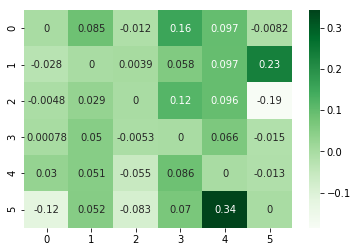

In [10]:
print('Visualization of transferability results:')
transfer = np.array_split(transferability, 6)
df_transfer = pandas.DataFrame.from_records(transfer)
df_transfer = df_transfer.T
#cm_trans = sns.light_palette("blue", as_cmap=True)
#df_transfer = df_transfer.style.background_gradient(cmap=cm_trans)
#df_transfer
sns.heatmap(df_transfer, cmap='Greens', annot=True)

In [12]:
# Rank Correlation of SVCCA mean model correlation (net similarity) and Transferability (Transfer Performance increase)
# All Branches
def rank_pearson_corr(transferability, svcca_corr_all):
    spearman_corr, spearman_pvalue = stats.spearmanr(transferability, svcca_corr_all)
    print("Spearman Correlation:", spearman_corr)
    print("Spearman p_value:", spearman_pvalue)
    pearson_corr, pearson_pvalue = stats.pearsonr(transferability, svcca_corr_all)
    print("Pearson Correlation:", pearson_corr)
    print("Pearson p_value:", pearson_pvalue)

In [16]:
# Rank (Spearman) and Pearson Correlation 
# without transferability=0 and net_similarity=1 for all branches
print('Rank and Pearson Correlation without transferability=0 and net_similarity=1 for all branches')
relevant_indices = [1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34]
transferability_no_zeros = np.array(transferability)
net_sim_no_ones = np.array(svcca_corr_all)
rank_pearson_corr(transferability_no_zeros[relevant_indices], net_sim_no_ones[relevant_indices])

Rank and Pearson Correlation without transferability=0 and net_similarity=1 for all branches
Spearman Correlation: 0.20845383759733035
Spearman p_value: 0.26897217902440945
Pearson Correlation: 0.19526696013433698
Pearson p_value: 0.30110237699062287


H0: Correlation = 0

Stress H0: positive spearman correlation = 0.20845

but p-value > 0.05. So we can not disprove H0.



# row-wise comparison of correlation, all branches

Try calculating the Correlation by just comparing convolutional layer 4, 5, 6, 7 (first conv row of model)

In [17]:
print('row_1:')
conv_row1 = [4, 5, 6, 7]
svcca_row1 = run_svcca_for_all_branches(conv_row1)
relevant_indices = [1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34]
transferability = np.array(transferability)
svcca_row1 = np.array(svcca_row1)
rank_pearson_corr(transferability[relevant_indices], svcca_row1[relevant_indices])

row_1:
m1_x1/m1_x1 Mean Model Correlation: 0.9985159195482425
m1_x1/m2_x1 Mean Model Correlation: 0.49373323901810096
m1_x1/m3_x1 Mean Model Correlation: 0.445877617919542
m1_x1/m4_x1 Mean Model Correlation: 0.8564876339657601
m1_x1/m5_x1 Mean Model Correlation: 0.806210247348248
m1_x1/m6_x1 Mean Model Correlation: 0.8326265241726409
m2_x2/m1_x2 Mean Model Correlation: 0.4920820506790916
m2_x2/m2_x2 Mean Model Correlation: 0.9987722920950097
m2_x2/m3_x2 Mean Model Correlation: 0.47106468215042535
m2_x2/m4_x2 Mean Model Correlation: 0.501757285756509
m2_x2/m5_x2 Mean Model Correlation: 0.49950575081632015
m2_x2/m6_x2 Mean Model Correlation: 0.4942511391367192
m3_x3/m1_x3 Mean Model Correlation: 0.47774267813660587
m3_x3/m2_x3 Mean Model Correlation: 0.479902759236775
m3_x3/m3_x3 Mean Model Correlation: 0.9934260526324707
m3_x3/m4_x3 Mean Model Correlation: 0.46168152692392495
m3_x3/m5_x3 Mean Model Correlation: 0.47376702628348105
m3_x3/m6_x3 Mean Model Correlation: 0.4495841833863673
m

Postitive correlation between transferability and net similarity

but p-value > 0.05. So we can not disprove H0.

Correlations for other rows:

In [21]:
print('row_2:')
conv_row2 = [8, 9, 10, 11]
svcca_row2 = np.array(run_svcca_for_all_branches(conv_row2))
rank_pearson_corr(transferability[relevant_indices], svcca_row2[relevant_indices])
print('row_3:')
conv_row3 = [12, 13, 14, 15]
svcca_row3 = np.array(run_svcca_for_all_branches(conv_row3))
rank_pearson_corr(transferability[relevant_indices], svcca_row3[relevant_indices])
print('row_4:')
conv_row4 = [16, 17, 18, 19]
svcca_row4 = np.array(run_svcca_for_all_branches(conv_row4))
rank_pearson_corr(transferability[relevant_indices], svcca_row4[relevant_indices])
print('row_5_pooling:')
conv_row5 = [20, 21, 22, 23]
svcca_row5 = np.array(run_svcca_for_all_branches(conv_row5))
rank_pearson_corr(transferability[relevant_indices], svcca_row5[relevant_indices])

row_2:
m1_x1/m1_x1 Mean Model Correlation: 0.9962188436903081
m1_x1/m2_x1 Mean Model Correlation: 0.45640891349167617
m1_x1/m3_x1 Mean Model Correlation: 0.3859858055043532
m1_x1/m4_x1 Mean Model Correlation: 0.7537478148590817
m1_x1/m5_x1 Mean Model Correlation: 0.6856012501051909
m1_x1/m6_x1 Mean Model Correlation: 0.772149732505812
m2_x2/m1_x2 Mean Model Correlation: 0.468085120233491
m2_x2/m2_x2 Mean Model Correlation: 0.9972647625587265
m2_x2/m3_x2 Mean Model Correlation: 0.43175920450013694
m2_x2/m4_x2 Mean Model Correlation: 0.46842216088517336
m2_x2/m5_x2 Mean Model Correlation: 0.4173055987749398
m2_x2/m6_x2 Mean Model Correlation: 0.47193942534183286
m3_x3/m1_x3 Mean Model Correlation: 0.3997200040818273
m3_x3/m2_x3 Mean Model Correlation: 0.43178698800379767
m3_x3/m3_x3 Mean Model Correlation: 0.9985920705208073
m3_x3/m4_x3 Mean Model Correlation: 0.43669264917193507
m3_x3/m5_x3 Mean Model Correlation: 0.4058036376760706
m3_x3/m6_x3 Mean Model Correlation: 0.4315304589388216

m6_x6/m4_x6 Mean Model Correlation: 0.7227164335430032
m6_x6/m5_x6 Mean Model Correlation: 0.7247418397571485
m6_x6/m6_x6 Mean Model Correlation: 0.9926697695220313
Spearman Correlation: 0.13815350389321468
Spearman p_value: 0.46658483426282193
Pearson Correlation: 0.19454778761878058
Pearson p_value: 0.30292130919105115


Row 4:

Spearman Correlation: 0.23381535038932147
Spearman p_value: 0.21365894749258096

p-value > 0.05

# Column-wise comparison of correlation (head-wise)

Try calculating the Correlation by just comparing convolutional layer 4, 8, 12, 16, 20 of the first head (revenue)

In [22]:
head1_layers = [4, 8, 12, 16, 20] # revenue
svcca_head1 = np.array(run_svcca_for_all_branches(head1_layers))
rank_pearson_corr(transferability[relevant_indices], svcca_head1[relevant_indices])

m1_x1/m1_x1 Mean Model Correlation: 0.9999911685817071
m1_x1/m2_x1 Mean Model Correlation: 0.6616904327452213
m1_x1/m3_x1 Mean Model Correlation: 0.6432691594666291
m1_x1/m4_x1 Mean Model Correlation: 0.8929700549058607
m1_x1/m5_x1 Mean Model Correlation: 0.8342911875127115
m1_x1/m6_x1 Mean Model Correlation: 0.8740219814857586
m2_x2/m1_x2 Mean Model Correlation: 0.6985290512887589
m2_x2/m2_x2 Mean Model Correlation: 0.999931992068561
m2_x2/m3_x2 Mean Model Correlation: 0.6603351709474556
m2_x2/m4_x2 Mean Model Correlation: 0.7226302577344986
m2_x2/m5_x2 Mean Model Correlation: 0.7332059673974528
m2_x2/m6_x2 Mean Model Correlation: 0.7125988272351745
m3_x3/m1_x3 Mean Model Correlation: 0.7242432774733694
m3_x3/m2_x3 Mean Model Correlation: 0.6599399602539111
m3_x3/m3_x3 Mean Model Correlation: 0.9999117019654333
m3_x3/m4_x3 Mean Model Correlation: 0.7169555613954044
m3_x3/m5_x3 Mean Model Correlation: 0.7422492936681
m3_x3/m6_x3 Mean Model Correlation: 0.7342478837776064
m4_x4/m1_x4 Me

Try calculating the Correlation by just comparing convolutional layer 5, 9, 13, 17, 21 of the second head (month)

In [23]:
head2_layers = [5, 9, 13, 17, 21] # month
svcca_head2 = np.array(run_svcca_for_all_branches(head2_layers))
rank_pearson_corr(transferability[relevant_indices], svcca_head2[relevant_indices])

m1_x1/m1_x1 Mean Model Correlation: 0.9505927633525653
m1_x1/m2_x1 Mean Model Correlation: 0.5751763489337894
m1_x1/m3_x1 Mean Model Correlation: 0.4706400819170007
m1_x1/m4_x1 Mean Model Correlation: 0.6577791705445752
m1_x1/m5_x1 Mean Model Correlation: 0.611429403184003
m1_x1/m6_x1 Mean Model Correlation: 0.6919961339726887
m2_x2/m1_x2 Mean Model Correlation: 0.5751763489337894
m2_x2/m2_x2 Mean Model Correlation: 0.9911267131408842
m2_x2/m3_x2 Mean Model Correlation: 0.7597006939281686
m2_x2/m4_x2 Mean Model Correlation: 0.602128630244296
m2_x2/m5_x2 Mean Model Correlation: 0.4951445285136467
m2_x2/m6_x2 Mean Model Correlation: 0.5400156510312601
m3_x3/m1_x3 Mean Model Correlation: 0.4706400819170006
m3_x3/m2_x3 Mean Model Correlation: 0.7597006939281687
m3_x3/m3_x3 Mean Model Correlation: 0.9911784656662818
m3_x3/m4_x3 Mean Model Correlation: 0.42909846022367437
m3_x3/m5_x3 Mean Model Correlation: 0.2802939002286082
m3_x3/m6_x3 Mean Model Correlation: 0.29098608390847763
m4_x4/m1_x

Try calculating the Correlation by just comparing convolutional layer 6, 10, 14, 18, 22 of the third head (weekday)

In [24]:
head3_layers = [6, 10, 14, 18, 22] # weekday
svcca_head3 = np.array(run_svcca_for_all_branches(head3_layers))
rank_pearson_corr(transferability[relevant_indices], svcca_head3[relevant_indices])

m1_x1/m1_x1 Mean Model Correlation: 0.997708014228585
m1_x1/m2_x1 Mean Model Correlation: 0.48098261943305215
m1_x1/m3_x1 Mean Model Correlation: 0.4957553338539006
m1_x1/m4_x1 Mean Model Correlation: 0.6513728641461063
m1_x1/m5_x1 Mean Model Correlation: 0.6301619251794639
m1_x1/m6_x1 Mean Model Correlation: 0.6416269105307956
m2_x2/m1_x2 Mean Model Correlation: 0.4809826194330521
m2_x2/m2_x2 Mean Model Correlation: 0.995538289043421
m2_x2/m3_x2 Mean Model Correlation: 0.4618018539956504
m2_x2/m4_x2 Mean Model Correlation: 0.4633629481471421
m2_x2/m5_x2 Mean Model Correlation: 0.4724579852695647
m2_x2/m6_x2 Mean Model Correlation: 0.47225326755047925
m3_x3/m1_x3 Mean Model Correlation: 0.49575533385390064
m3_x3/m2_x3 Mean Model Correlation: 0.46180185399565055
m3_x3/m3_x3 Mean Model Correlation: 0.9937618570423554
m3_x3/m4_x3 Mean Model Correlation: 0.5093174911724708
m3_x3/m5_x3 Mean Model Correlation: 0.5065893416855938
m3_x3/m6_x3 Mean Model Correlation: 0.5039479428170294
m4_x4/m1

Try calculating the Correlation by just comparing convolutional layer 7, 11, 15, 19, 23 of the third head (year)

In [25]:
head4_layers = [7, 11, 15, 19, 23] # year
svcca_head4 = np.array(run_svcca_for_all_branches(head4_layers))
rank_pearson_corr(transferability[relevant_indices], svcca_head4[relevant_indices])

m1_x1/m1_x1 Mean Model Correlation: 0.9999999999
m1_x1/m2_x1 Mean Model Correlation: 0.11475521520801442
m1_x1/m3_x1 Mean Model Correlation: 0.11352556307473609
m1_x1/m4_x1 Mean Model Correlation: 0.8976023947107972
m1_x1/m5_x1 Mean Model Correlation: 0.7517842040516198
m1_x1/m6_x1 Mean Model Correlation: 0.9239923449878511
m2_x2/m1_x2 Mean Model Correlation: 0.11475521520801442
m2_x2/m2_x2 Mean Model Correlation: 0.9999999999
m2_x2/m3_x2 Mean Model Correlation: 0.037621694384721314
m2_x2/m4_x2 Mean Model Correlation: 0.1145040399785647
m2_x2/m5_x2 Mean Model Correlation: 0.12029946621149831
m2_x2/m6_x2 Mean Model Correlation: 0.12728323007130374
m3_x3/m1_x3 Mean Model Correlation: 0.11352556307473609
m3_x3/m2_x3 Mean Model Correlation: 0.037621694384721314
m3_x3/m3_x3 Mean Model Correlation: 0.9999999999
m3_x3/m4_x3 Mean Model Correlation: 0.1049227848914582
m3_x3/m5_x3 Mean Model Correlation: 0.04866029027584332
m3_x3/m6_x3 Mean Model Correlation: 0.10081103628077218
m4_x4/m1_x4 Mean

There is a positive correlation between transferability and net similarity if we look at the distinct heads of the multihead CNN models (revenue, month, weekday and year).

but p-value > 0.05. So we can not disprove H0.

# Single layer visualization (layer 4 to 23), Branch 1 as Target

In [26]:
conv_layers = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

model_corr = []
for act1 in act1_list:
    layer_corr = []
    for conv in conv_layers:
        corr = calculate_SVCCA(act1_target, act1, conv)
        layer_corr.append(corr)
    model_corr.append(layer_corr)

In [27]:
df = pandas.DataFrame.from_records(model_corr, columns=conv_layers)

The following table/df shows the distinct layer SVCCA correlations (from layer 4 to layer 23) 
for target branch 1 compared to branch 1 to 6 (index 0-5)

In [28]:
layerwise = df.T

cm = sns.light_palette("green", as_cmap=True)
branch1 = layerwise.style.background_gradient(cmap=cm)
branch1

,0,1,2,3,4,5
4,0.999959,0.799834,0.670076,0.912262,0.85413,0.910757
5,0.994107,0.687403,0.590704,0.759915,0.6831,0.751917
6,0.999998,0.420979,0.429032,0.772768,0.773879,0.697219
7,1,0.0667171,0.0936983,0.981007,0.913732,0.970613
8,0.999998,0.458258,0.576877,0.903913,0.816748,0.828486
9,0.984958,0.711813,0.378733,0.611947,0.61591,0.713789
10,0.99992,0.491001,0.482916,0.605042,0.59844,0.633623
11,1,0.164564,0.105418,0.894089,0.711307,0.912701
12,1,0.698199,0.735502,0.880701,0.816127,0.861639
13,0.94785,0.528893,0.473636,0.660935,0.61405,0.831725


The model of branch1 is positive correlated to all other 5 branches.

It's more similar to 4, 5, 6 than to 2 and 3.

In the layers 7, 11, 15, 19, 23 model of branch1 is not correlated to model2 and model3. quite different in SVCCA correlation.


In [29]:
# mean model correlation of target branch 1 crosswise with branch1 to branch6 (index 0-5)
layerwise.mean()

0    0.987073
1    0.458151
2    0.430798
3    0.774931
4    0.706917
5    0.782909
dtype: float64